In [43]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch import tensor
import os

import imageio
from PIL import Image, ImageDraw, ImageFont

In [44]:
class Policy(nn.Module):
    def __init__(self, n_state, n_hidden, n_action):
       super().__init__()

       self.fc1=nn.Linear(n_state,n_hidden)
       self.fc2=nn.Linear(n_hidden,n_hidden)
       self.fc3=nn.Linear(n_hidden,n_action)
       

    def forward(self,x): 

       x=self.fc1(x)
       x=F.relu(x) 
       x=self.fc2(x)
       x=F.relu(x) 
       action_prob=torch.softmax(self.fc3(x),dim=-1)

       return action_prob


In [45]:
def agent (number_episode, gamma, count_num, render, n_hidden):
    
    env = gym.make("CartPole-v1", render_mode="human" if render else None)
    num_state=env.observation_space.shape[0]
    num_action= env.action_space.n

    network=Policy( num_state,n_hidden,num_action)
    optimizer= optim.Adam(network.parameters(), lr=0.001)

    
    counter=0

    all_rewards=[]
    all_probs=[]
    episode_rewards_list = []

    for i in range(number_episode):

        state, info = env.reset()
        terminated=False
        truncated=False
        rewards=[]
        log_probs=[]

        while not terminated and not truncated:

            state = torch.tensor(state, dtype=torch.float32)
            probs=network(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, terminated, truncated, info = env.step(action.item())
 
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)

            state = next_state

        counter+=1
        
        episode_reward = sum(rewards)
        episode_rewards_list.append(episode_reward)

    

        # ---- Print average reward every 100 episodes ----
        if (i + 1) % 100 == 0:
            avg_reward = sum(episode_rewards_list[-100:]) / 100
            print(f"Episode {i + 1}: average reward (last 100 episodes) = {avg_reward:.2f}")


        G=0
        returns = []

        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns=torch.tensor(returns, dtype=torch.float32)   
        
        all_probs.append(torch.stack(log_probs))
        all_rewards.append(returns)

        if counter >= count_num :
            
            log_probs_tensor = torch.cat(all_probs)
            returns_tensor = torch.cat(all_rewards)
            
            #returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

            loss = -(log_probs_tensor * returns_tensor).sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_probs = []
            all_rewards = []
            counter = 0
    env.close()

            # ---- Plot average reward per 100 episodes ----
    window = 100
    rewards = np.array(episode_rewards_list)
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

   



    plt.figure(figsize=(12,6))
    plt.plot(range(window-1, len(rewards)), moving_avg)
    plt.title(f'Moving Average of Rewards (window={window})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.savefig("moving_average_rewards.png")
    plt.show()
           

    return network

In [46]:
def test_policy_max(network, n_episodes=5, render=True):
    env = gym.make("CartPole-v1", render_mode="rgb_array" if render else None)
    os.makedirs("results/videos", exist_ok=True)
    
    for i in range(n_episodes):
        state, info = env.reset()
        terminated = False
        truncated = False
        frames = []
        total_reward = 0
        
        while not terminated and not truncated:

           
            frame = env.render()
            frames.append(np.array(frame, dtype=np.uint8))
            state_tensor = torch.tensor(state, dtype=torch.float32)
            probs = network(state_tensor)
            
            # Choose max probability action
            action = torch.argmax(probs).item()
            
            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            state = next_state

            if terminated or truncated:
                        # Final frame
                        frames.append(env.render())
                        break

        gif_path = f"results/videos/cartpole_episode_{i}.gif"
        imageio.mimsave(gif_path, frames, fps=20)
        print("Saved GIF:", gif_path)             
        
        print(f"Test Episode {i + 1}: total reward = {total_reward}")
    
    env.close()



Episode 100: average reward (last 100 episodes) = 19.91
Episode 200: average reward (last 100 episodes) = 20.93
Episode 300: average reward (last 100 episodes) = 22.60
Episode 400: average reward (last 100 episodes) = 22.30
Episode 500: average reward (last 100 episodes) = 23.48
Episode 600: average reward (last 100 episodes) = 23.84
Episode 700: average reward (last 100 episodes) = 25.93
Episode 800: average reward (last 100 episodes) = 28.17
Episode 900: average reward (last 100 episodes) = 30.51
Episode 1000: average reward (last 100 episodes) = 28.70
Episode 1100: average reward (last 100 episodes) = 32.74
Episode 1200: average reward (last 100 episodes) = 35.11
Episode 1300: average reward (last 100 episodes) = 38.56
Episode 1400: average reward (last 100 episodes) = 40.71
Episode 1500: average reward (last 100 episodes) = 44.17
Episode 1600: average reward (last 100 episodes) = 51.05
Episode 1700: average reward (last 100 episodes) = 59.09
Episode 1800: average reward (last 100 e

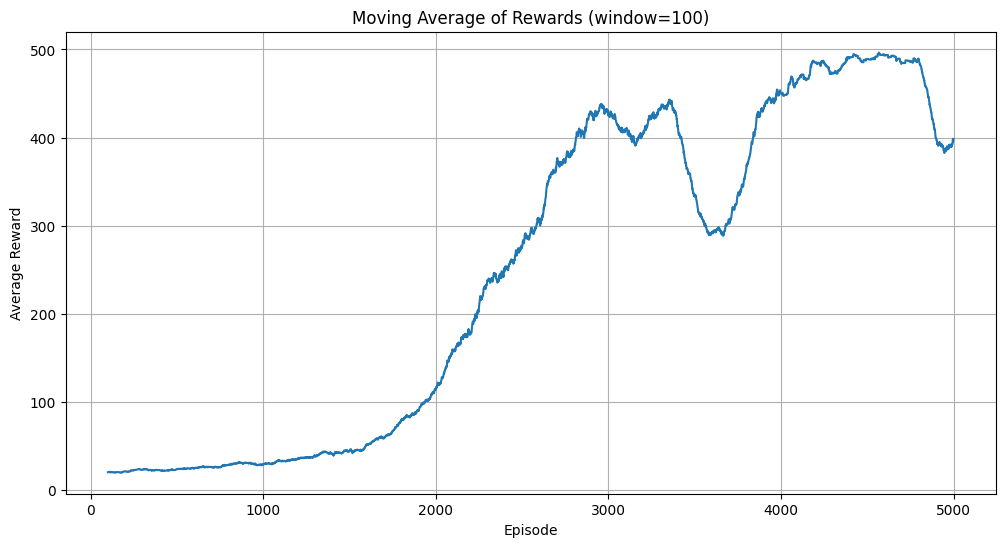

Saved GIF: results/videos/cartpole_episode_0.gif
Test Episode 1: total reward = 435.0
Saved GIF: results/videos/cartpole_episode_1.gif
Test Episode 2: total reward = 500.0
Saved GIF: results/videos/cartpole_episode_2.gif
Test Episode 3: total reward = 500.0
Saved GIF: results/videos/cartpole_episode_3.gif
Test Episode 4: total reward = 492.0
Saved GIF: results/videos/cartpole_episode_4.gif
Test Episode 5: total reward = 500.0


In [47]:
if __name__ == "__main__":

    train_policy=agent (number_episode=5000, gamma=0.99, count_num=20, render=False, n_hidden=32)
   
    test=test_policy_max(train_policy, n_episodes=5, render=True)

    